# DaKanjiRecognizer - CNN notebook

## Setup

Import the needed libraries.

In [1]:
#std lib
import sys
import os
import random
import math
import pickle

#add the projects python files to the path
#sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

#reading the dataset
from etldr.etl_data_reader import ETLDataReader
from etldr.etl_character_groups import ETLCharacterGroups
from etldr.etl_data_names import ETLDataNames

#data handling
import PIL
import numpy as np

#ML
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

#creating one hot encodings
from sklearn.preprocessing import LabelBinarizer

#plotting/showing graphics
import matplotlib.pyplot as plt
from IPython.display import Image
#define a font to show japanese characters in matplotlib figures
import matplotlib.font_manager as fm
font = fm.FontProperties(fname=os.path.join("font", "NotoSerifCJKjp-Regular.otf"), size=20)

If a GPU with native 16 bit float support (ex.: RTX 20/30-series) is available, set support for it here.

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('float32')
#policy = mixed_precision.Policy('mixed_float16')      # <-- uncomment this
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float32
Variable dtype: float32


## Preparing the data

The [ETL Character data set](http://etlcdb.db.aist.go.jp/) which I am using is a data set with multiple sub sets (ETL1 - ETL7, ETL8B, ETL8G, ETL9B and ETL9G). <br/>
After unpacking the data set I renamed all folders and files to have a uniform naming scheme: "ETLX/ETLX_Y". "X" is the number of the subset and Y the part of the subset. Also ETL7S was removed (ETL7L just smaller), the following renaming was also done: <br/>
ETL8B $\rightarrow$ ETL1, ETL8G $\rightarrow$ ETL9, ETL9B $\rightarrow$ ETL10 and ETL9G $\rightarrow$ ETL11.<br/>
This leads to the following data set structure: <br/> 

| name  |   type  |                    content                                              |   res   | Bit depth |    code    | samples perlabel | total samples |
|:-----:|:-------:|:-----------------------------------------------------------------------:|:-------:|:---------:|:----------:|:----------------:|:-------------:|
| ETL1  | M-Type  | Numbers <br/> Roman <br/> Symbols <br/> Katakana                        |  64x63  |     4     | JIS X 0201 |   ~1400          |     141319    |
| ETL2  | K-Type  | Hiragana <br/> Katakana <br/> Kanji <br/> Roman <br/> Symbols           |  60x60  |     6     |    CO59    |     ~24          |      52796    |
| ETL3  | C-Type  | Numeric <br/> Capital Roman <br/> Symbols                               |  72x76  |     4     | JIS X 0201 |     200          |       9600    |
| ETL4  | C-Type  | Hiragana                                                                |  72x76  |     4     | JIS X 0201 |     120          |       6120    |
| ETL5  | C-Type  | Katakana                                                                |  72x76  |     4     | JIS X 0201 |    ~200          |      10608    |
| ETL6  | M-Type  | Katakana <br/> Symbols                                                  |  64x63  |     4     | JIS X 0201 |    1383          |     157662    |
| ETL7  | M-Type  | Hiragana <br/> Symbols                                                  |  64x63  |     4     | JIS X 0201 |     160          |      16800    |
| ETL8  | 8B-Type | Hiragana <br/> Kanji                                                    |  64x63  |     1     | JIS X 0208 |     160          |     157662    |
| ETL9  | 8G-Type | Hiragana <br/> Kanji                                                    | 128x127 |     4     | JIS X 0208 |     200          |     607200    |
| ETL10 | 9B-Type | Hiragana <br/> Kanji                                                    |  64x63  |     1     | JIS X 0208 |     160          |     152960    |
| ETL11 | 9G-Type | Hiragana <br/> Kanji                                                    | 128x127 |     4     | JIS X 0208 |     200          |     607200    |


Because the provided data set is distributed in a proprietary binary data format and therefore a little hard to handle I created a ```ERL_data_reader```-package. This package can be found [here](https://github.com/CaptainDario/ETL_data_reader).
The specific dataformat is C-struct like for types: M, 8B, 8G, 9B, 9G. But the types C and K have a 6-bit code. All codes can be found on the [official website.](http://etlcdb.db.aist.go.jp/file-formats-and-sample-unpacking-code)
I used the [struct module](https://docs.python.org/3/library/struct.html) and the [bitstring module](https://pypi.org/project/bitstring/) to unpack the binary data. <br/>

First an instance of the ```ERL_data_reader``` -class is needed.
The path parameter should lead to the folder in which all parts of the ETL data set can be found.

In [3]:
path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "dataset")
reader = ETLDataReader(path)

Now a whole data set can be read with the method ```ERL_data_reader.read_data_set(path, data_set_name)```.<br/>
Or parts of a data set can be loaded with ```ERL_data_reader.read_dataset_part(path, data_set_name)```. <br/>
Where ```path``` is the path to the data set file and ```dataset_id``` is the identifier of the sub data set (ETL1, ETL2, etc.).<br/>


I will load the first part of all eleven data sets.


In [4]:
imgs, labels = [], []

for _type in ETLDataNames:
    
    img, label = reader.read_dataset_file(1, _type)

    imgs.append(img)
    labels.append(label)

  0%|          | 0/11560 [00:00<?, ?it/s]

  0%|          | 0/9056 [00:00<?, ?it/s]

  0%|          | 0/4800 [00:00<?, ?it/s]

  0%|          | 0/6120 [00:00<?, ?it/s]

  0%|          | 0/10608 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/51200 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/121440 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

After reading a file of all data sets, display some random samples from each. The title shows the label and the index in the data set.

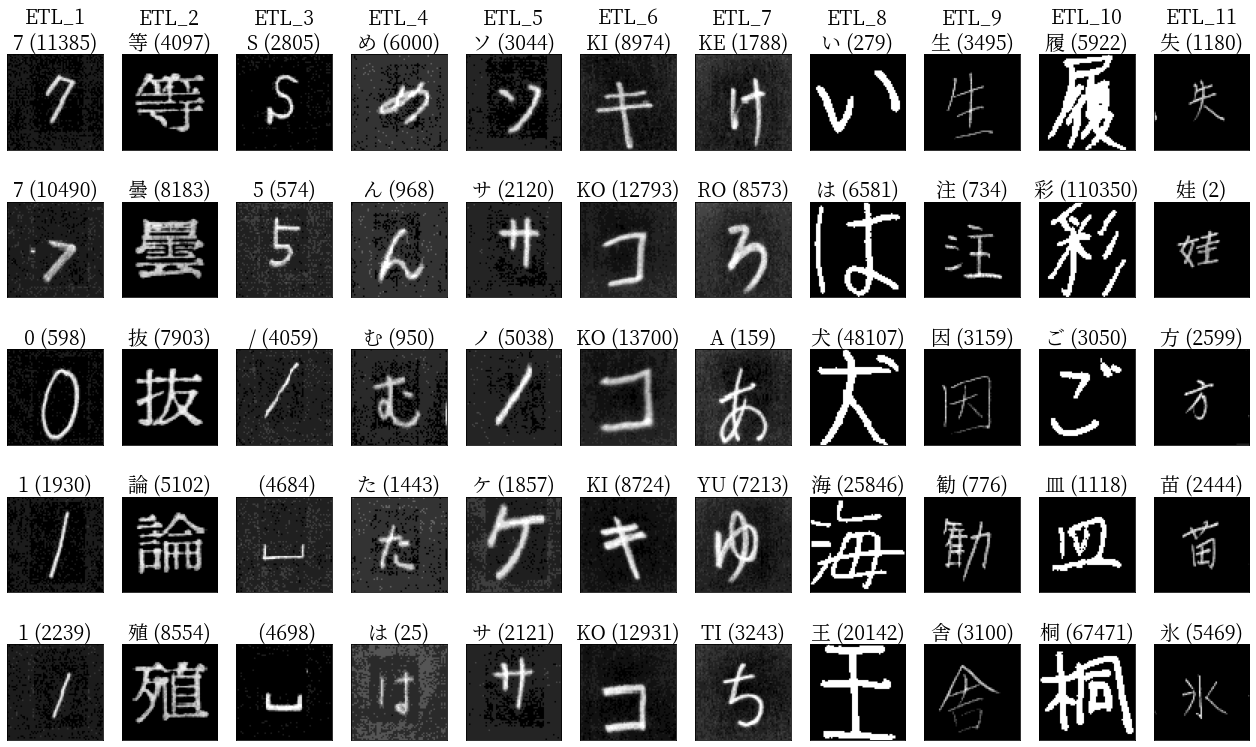

In [5]:
import random

x_length, y_length = len(imgs), 5

fig, axs = plt.subplots(y_length, x_length)
plt.subplots_adjust(right=3.0, top=2.6)

for x in range(x_length):
    for y in range(y_length):

        rnd = random.randint(0, len(imgs[x]) - 1)

        #get a random sample
        rand_img = np.array(imgs[x][rnd])
        #setup the sample
        tmp_ax = axs[y, x]
        #put the data set name on top of every column
        title = ("ETL_" + str(x + 1) + "\n") if y == 0 else ""
        title += str(labels[x][rnd]) + " (" + str(rnd) + ")"
        tmp_ax.set_title(title, font=font)
        tmp_ax.tick_params(axis="both", which="both",
                            bottom=False, top=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        #show it
        tmp_ax.imshow(rand_img.astype("float32"), cmap="gray")

Now train a model on the loaded data set. <br/>

Because the data sets are huge let's first check that the GPU is available to speed up training.

In [4]:
print("GPUs Available: ", tf.test.gpu_device_name())

GPUs Available:  /device:GPU:0


Now load all data set entries wich contain a Kanji character.

In [6]:
x, y = reader.read_dataset_whole(ETLCharacterGroups.kanji)

Loading all data set files (ETL1_x) from: E:\projects\DaKanjiRecognizerML\dataset\ETL1...


  0%|          | 0/11560 [00:00<?, ?it/s]

  0%|          | 0/11560 [00:00<?, ?it/s]

  0%|          | 0/11560 [00:00<?, ?it/s]

  0%|          | 0/11560 [00:00<?, ?it/s]

  0%|          | 0/11560 [00:00<?, ?it/s]

  0%|          | 0/11560 [00:00<?, ?it/s]

  0%|          | 0/11288 [00:00<?, ?it/s]

  0%|          | 0/11288 [00:00<?, ?it/s]

  0%|          | 0/11287 [00:00<?, ?it/s]

  0%|          | 0/11288 [00:00<?, ?it/s]

  0%|          | 0/11288 [00:00<?, ?it/s]

  0%|          | 0/11287 [00:00<?, ?it/s]

  0%|          | 0/4233 [00:00<?, ?it/s]

Loading all data set files (ETL2_x) from: E:\projects\DaKanjiRecognizerML\dataset\ETL2...


  0%|          | 0/9056 [00:00<?, ?it/s]

  0%|          | 0/10480 [00:00<?, ?it/s]

  0%|          | 0/11360 [00:00<?, ?it/s]

  0%|          | 0/10480 [00:00<?, ?it/s]

  0%|          | 0/11420 [00:00<?, ?it/s]

Loading all data set files (ETL3_x) from: E:\projects\DaKanjiRecognizerML\dataset\ETL3...


  0%|          | 0/4800 [00:00<?, ?it/s]

  0%|          | 0/4800 [00:00<?, ?it/s]

Loading all data set files (ETL4_x) from: E:\projects\DaKanjiRecognizerML\dataset\ETL4...


  0%|          | 0/6120 [00:00<?, ?it/s]

Loading all data set files (ETL5_x) from: E:\projects\DaKanjiRecognizerML\dataset\ETL5...


  0%|          | 0/10608 [00:00<?, ?it/s]

Loading all data set files (ETL6_x) from: E:\projects\DaKanjiRecognizerML\dataset\ETL6...


  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/6915 [00:00<?, ?it/s]

Loading all data set files (ETL7_x) from: E:\projects\DaKanjiRecognizerML\dataset\ETL7...


  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/7200 [00:00<?, ?it/s]

Loading all data set files (ETL8_x) from: E:\projects\DaKanjiRecognizerML\dataset\ETL8...


  0%|          | 0/51200 [00:00<?, ?it/s]

  0%|          | 0/51200 [00:00<?, ?it/s]

  0%|          | 0/51516 [00:00<?, ?it/s]

Loading all data set files (ETL9_x) from: E:\projects\DaKanjiRecognizerML\dataset\ETL9...


  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

  0%|          | 0/4780 [00:00<?, ?it/s]

Loading all data set files (ETL10_x) from: E:\projects\DaKanjiRecognizerML\dataset\ETL10...


  0%|          | 0/121440 [00:00<?, ?it/s]

  0%|          | 0/121440 [00:00<?, ?it/s]

  0%|          | 0/121440 [00:00<?, ?it/s]

  0%|          | 0/121440 [00:00<?, ?it/s]

  0%|          | 0/124476 [00:00<?, ?it/s]

Loading all data set files (ETL11_x) from: E:\projects\DaKanjiRecognizerML\dataset\ETL11...


  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

  0%|          | 0/12144 [00:00<?, ?it/s]

After loading the data, first create a one hot encoding of them.

In [9]:
#one hot encode the labels
lb = LabelBinarizer()
lb.fit(y)
o_y = lb.transform(y)

In [32]:
# concat classes-list to string
s = "".join([i for i in lb.classes_])

# save a list of all labels into a .txt file
with open("../labels.txt", "w+", encoding="utf8") as f:
    f.write(s)

Because the one hot encoding needs to be decoded in the app the LabelBinarizer needs to be saved.

In [6]:
with open(os.path.join('labels'), 'wb') as f:
    pickle.dump(lb, f)

The data will allways be loaded in the same order. Therefore it needs to be shuffled before training.

In [7]:
# because the data is ordered shuffle it
rng_state = np.random.get_state()
np.random.shuffle(x)
np.random.set_state(rng_state)
np.random.shuffle(y)

## Creating a CNN

Now a CNN can be defined.

In [9]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(64, 64, 1), kernel_size=(3, 3), activation='relu', filters=32, name="conv2D_1_input"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_1"),
    
    tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=32, name="conv2D_2"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_2"),
    
    tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=64, name="conv2D_3"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_3"),
    
    tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=128, name="conv2D_4"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_4"),
    
    tf.keras.layers.Flatten(name="flatten_1"),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Dense(2048, name="dense_1"),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Dense(len(set(y)), name="dense_2"),

    #set the dtype to float32 for numerical stability
    tf.keras.layers.Softmax(dtype="float32", name="softmax_1_output") 
], name="DaKanjiRecognizer")

print(model.output_shape)
model.summary()

(None, 2967)
Model: "DaKanjiRecognizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_1_input (Conv2D)      (None, 62, 62, 32)        320       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 31, 31, 32)        0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 14, 14, 32)        0         
_________________________________________________________________
conv2D_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
maxpool_3 (MaxPooling2D)     (None, 6, 6, 64)          0         
_________________________________________________________________
conv2D_4 (Conv2D)            (None, 

Set the optimizer, loss function and compile the model

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-08,)

#optionally load stored weights to resume training
tf_checkpoints_dir = os.path.join(os.path.dirname(os.getcwd()), "model", "tf", "kanji_only", "float32", "check_points")
#model.load_weights(os.path.join(tf_checkpoints_dir, "The saved model"))

model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=['accuracy'])

Finally train the model on the data set (in case of an Interrupt creates checkpoints).

In [ ]:
#path where to model should be saved
tf_models_dir = os.path.join(os.path.dirname(os.getcwd()), "model", "tf", "kanji_only", "floate")

In [21]:
#checkpoints setup
filepath = os.path.join(tf_models_dir, "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#train the model
hist = model.fit(x, o_y, epochs=100, validation_split=0.3, batch_size=256, shuffle=True, callbacks=callbacks_list)

Epoch 1/100
4158/4158 [==============================] - 149s 35ms/step - loss: 5.4980 - accuracy: 0.1598 - val_loss: 0.9445 - val_accuracy: 0.7843

Epoch 00001: val_accuracy improved from -inf to 0.78435, saving model to E:\projects\DaKanjiRecognizer\model\tf\kanji_only\weights-improvement-01-0.78.hdf5
Epoch 2/100
4158/4158 [==============================] - 104s 25ms/step - loss: 1.2126 - accuracy: 0.6945 - val_loss: 0.4466 - val_accuracy: 0.8898

Epoch 00002: val_accuracy improved from 0.78435 to 0.88983, saving model to E:\projects\DaKanjiRecognizer\model\tf\kanji_only\weights-improvement-02-0.89.hdf5
Epoch 3/100
4158/4158 [==============================] - 103s 25ms/step - loss: 0.6857 - accuracy: 0.8157 - val_loss: 0.2977 - val_accuracy: 0.9242

Epoch 00003: val_accuracy improved from 0.88983 to 0.92421, saving model to E:\projects\DaKanjiRecognizer\model\tf\kanji_only\weights-improvement-03-0.92.hdf5
Epoch 4/100
4158/4158 [==============================] - 104s 25ms/step - loss:

4158/4158 [==============================] - 101s 24ms/step - loss: 0.0673 - accuracy: 0.9787 - val_loss: 0.0644 - val_accuracy: 0.9837

Epoch 00028: val_accuracy did not improve from 0.98371
Epoch 29/100
4158/4158 [==============================] - 103s 25ms/step - loss: 0.0658 - accuracy: 0.9793 - val_loss: 0.0634 - val_accuracy: 0.9840

Epoch 00029: val_accuracy improved from 0.98371 to 0.98398, saving model to E:\projects\DaKanjiRecognizer\model\tf\kanji_only\weights-improvement-29-0.98.hdf5
Epoch 30/100
4158/4158 [==============================] - 101s 24ms/step - loss: 0.0630 - accuracy: 0.9802 - val_loss: 0.0627 - val_accuracy: 0.9836

Epoch 00030: val_accuracy did not improve from 0.98398
Epoch 31/100
4158/4158 [==============================] - 102s 24ms/step - loss: 0.0612 - accuracy: 0.9804 - val_loss: 0.0610 - val_accuracy: 0.9844

Epoch 00031: val_accuracy improved from 0.98398 to 0.98438, saving model to E:\projects\DaKanjiRecognizer\model\tf\kanji_only\weights-improvemen

Epoch 61/100
4158/4158 [==============================] - 103s 25ms/step - loss: 0.0344 - accuracy: 0.9886 - val_loss: 0.0500 - val_accuracy: 0.9879

Epoch 00061: val_accuracy did not improve from 0.98812
Epoch 62/100
4158/4158 [==============================] - 103s 25ms/step - loss: 0.0336 - accuracy: 0.9890 - val_loss: 0.0511 - val_accuracy: 0.9881

Epoch 00062: val_accuracy did not improve from 0.98812
Epoch 63/100
4158/4158 [==============================] - 103s 25ms/step - loss: 0.0341 - accuracy: 0.9890 - val_loss: 0.0515 - val_accuracy: 0.9882

Epoch 00063: val_accuracy improved from 0.98812 to 0.98822, saving model to E:\projects\DaKanjiRecognizer\model\tf\kanji_only\weights-improvement-63-0.99.hdf5
Epoch 64/100
4158/4158 [==============================] - 102s 25ms/step - loss: 0.0333 - accuracy: 0.9892 - val_loss: 0.0511 - val_accuracy: 0.9883

Epoch 00064: val_accuracy improved from 0.98822 to 0.98830, saving model to E:\projects\DaKanjiRecognizer\model\tf\kanji_only\weigh

Epoch 95/100
4158/4158 [==============================] - 100s 24ms/step - loss: 0.0240 - accuracy: 0.9921 - val_loss: 0.0463 - val_accuracy: 0.9894

Epoch 00095: val_accuracy did not improve from 0.98977
Epoch 96/100
4158/4158 [==============================] - 100s 24ms/step - loss: 0.0237 - accuracy: 0.9922 - val_loss: 0.0467 - val_accuracy: 0.9898

Epoch 00096: val_accuracy did not improve from 0.98977
Epoch 97/100
4158/4158 [==============================] - 102s 24ms/step - loss: 0.0239 - accuracy: 0.9922 - val_loss: 0.0459 - val_accuracy: 0.9898

Epoch 00097: val_accuracy did not improve from 0.98977
Epoch 98/100
4158/4158 [==============================] - 103s 25ms/step - loss: 0.0239 - accuracy: 0.9921 - val_loss: 0.0463 - val_accuracy: 0.9899

Epoch 00098: val_accuracy improved from 0.98977 to 0.98986, saving model to E:\projects\DaKanjiRecognizer\model\tf\kanji_only\weights-improvement-98-0.99.hdf5
Epoch 99/100
4158/4158 [==============================] - 100s 24ms/step - l

## Evaluating the model

After training plot the loss and accuracy for the test and validation sets.

Text(0, 0.5, 'val_loss')

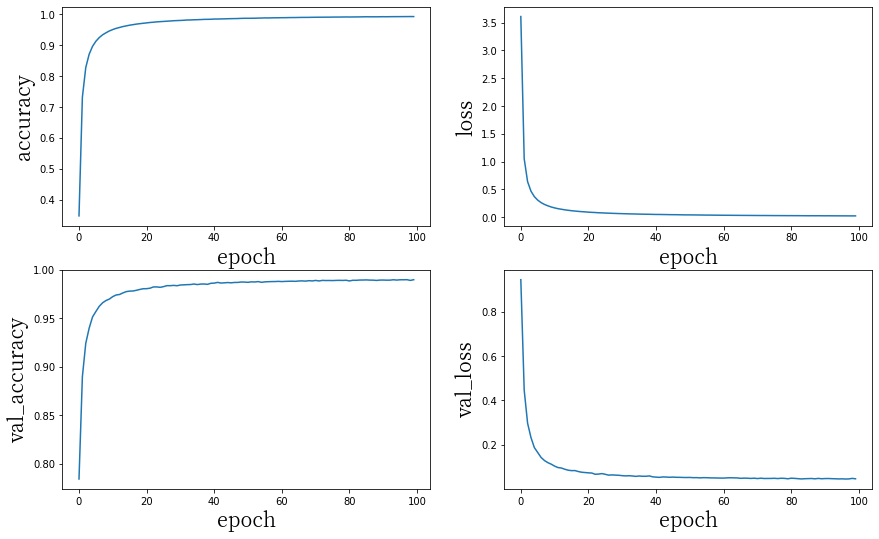

In [22]:
fig, axs = plt.subplots(2, 2)

plt.subplots_adjust(right=2.0, top=1.8)

axs[0, 0].plot(hist.history["accuracy"])
axs[0, 0].set_xlabel("epoch", font=font)
axs[0, 0].set_ylabel("accuracy", font=font)

axs[0, 1].plot(hist.history["loss"])
axs[0, 1].set_xlabel("epoch", font=font)
axs[0, 1].set_ylabel("loss", font=font)

axs[1, 0].plot(hist.history["val_accuracy"])
axs[1, 0].set_xlabel("epoch", font=font)
axs[1, 0].set_ylabel("val_accuracy", font=font)

axs[1, 1].plot(hist.history["val_loss"])
axs[1, 1].set_xlabel("epoch", font=font)
axs[1, 1].set_ylabel("val_loss", font=font)

The graphs look good. A training accuracy of 99% and a validation accuracy of 98% was reached.<br/>
Let's now make a prediction.

In [12]:
# reload the model from file if necessary
tf_models_dir = os.path.join(os.path.dirname(os.getcwd()), "model", "tf", "kanji_only", "float32")
#model = tf.keras.models.load_model(os.path.join(tf_model_dir, "checkpoints"))

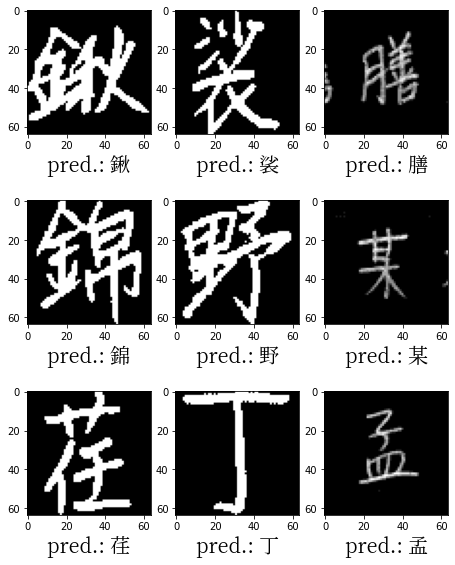

In [13]:
fig, axs = plt.subplots(3, 3)
plt.subplots_adjust(right=1.1, top=2)

for _x in range(3):
    for _y in range(3):
        #get a random sample
        sample = x[random.randint(0, len(x)-1)]

        #show the sample so that it can be validated
        axs[_x, _y].imshow(sample.astype("float32"), cmap="gray")
        
        out = model(sample.reshape(1, 64, 64, 1), training=False)
        out_np = np.array(out)
        
        prediction = lb.inverse_transform(out_np)
        axs[_x, _y].set_xlabel("pred.: " + str(prediction[0]), font=font)
    

## Saving the model

The model is perfoming very well therefore save the trained model as a "*.savemodel" file.

In [23]:
tf_models_dir = os.path.join(os.path.dirname(os.getcwd()), "model", "tf", "kanji_only", "float32")
model.save(tf_models_dir)

INFO:tensorflow:Assets written to: E:\projects\DaKanjiRecognizer\model\tf\kanji_only\float32\assets


Finally convert the model to a TF-Light model to be used in other applications ([DaKanjiRecognizer Desktop](https://github.com/CaptainDario/DaKanjiRecognizer-Desktop))

In [25]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(tf_models_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
